# ADA PROJECT - Amazon Kindle User Experience
## MILESTONE 2
### E. Bonvin, D. Dudzicz, X. Pantet

In [81]:
#Imports of various library needed for the notebook
import pandas as pd

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as snb
import os.path
import statistics

#PySpark SQL context creation
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(spark)

In [174]:
#Global variable definitions
DATA_FOLDER = 'data/'
RESULT_FOLDER = 'results/'

#Name of the datasets files downloaded from http://jmcauley.ucsd.edu/data/amazon/
RATINGS_KINDLE = 'ratings_Kindle_Store.csv'
RATINGS_BOOKS = 'ratings_Books.csv'

In this first milestone, we proceed to a first exploration of the data. In this analysis, we focus on the quantitive aspect of the data. For this purpose we focus on the ratings datasets from http://jmcauley.ucsd.edu/data/amazon/ of the kindle and the books. These contain all the reviews gathered by J. McAuley, C. Targett, J. Shi, A. van den Hengel but only retains the four following fields:
- User ID: anonimized Amazon customer ID
- Asin: The ID of the product purchased
- Ratings: The product review rating in a 1 to 5 scale
- Timestamp: The daytime timestamp in the UNIX timestamp format

As mentionned previously, the Asin doesn't allow us to compare books and corresponding kindle ebooks. Indeed, the number cannot be compared nor infered in an easy manner. 

We read the report from last year course group by Lee, Jollès and Lamonato. The authors explain all the different techniques they pursued in order to be able to compare books and ebooks directly. The webscraping was unsuccesfull due to amazon bot recognition and the API provided by AWS, when purchasing an EC2 plan wasn't uncluent as well. Eventually, the comparison was made on the authors but yielded very few data (94 entries to be precise). Given this, we decided to chose another approach for our work.

We decide to compare the overall user experience regarding the kindle and the classical book reading by comparing reviews by users who wrote them. Indeed, we suppose that the medium can affect the general trend in reviews of a given customer and we will try to observe it. It is doable given that the anonimized User ID is consistent throughout the whole reviews dataset including both books and kindle ebooks sub-categories which make possible joining on this field.

### Data Cleaning
In our case the data is very consistent and well structured given the extensive work of J. McAuley et al. which means that we don't have to do very much in this step. We only focus on the ratings datasets for this part of the project given that we focus on exploratory statistics of the data and not an extensive analysis as in the case of a sentiment analysis for which we would need the complete data review set.

### Load data

In [175]:
# Ratings datasets

# Kindle
df_ratings_kindle = spark.read.csv(DATA_FOLDER + RATINGS_KINDLE, header = False, schema = RATINGS_SCHEMA)
print("---Kindle rating data sample---")
print(df_ratings_kindle.head(5))

# Books
df_ratings_books = spark.read.csv(DATA_FOLDER + RATINGS_BOOKS, header = False, schema = RATINGS_SCHEMA)
print("---Books rating data sample---")
print(df_ratings_books.head(5))

---Kindle rating data sample---
[Row(User='A2GZ9GFZV1LWB0', Asin='1603420304', Ratings=4.0, Timestamp=1405209600), Row(User='A1K7VSUDCVAPW8', Asin='1603420304', Ratings=3.0, Timestamp=1282176000), Row(User='A35J5XRE5ZT6H2', Asin='1603420304', Ratings=4.0, Timestamp=1365206400), Row(User='A3DGZNFSMNWSX5', Asin='1603420304', Ratings=4.0, Timestamp=1285632000), Row(User='A2CVDQ6H36L4VL', Asin='1603420304', Ratings=5.0, Timestamp=1342396800)]
---Books rating data sample---
[Row(User='AH2L9G3DQHHAJ', Asin='0000000116', Ratings=4.0, Timestamp=1019865600), Row(User='A2IIIDRK3PRRZY', Asin='0000000116', Ratings=1.0, Timestamp=1395619200), Row(User='A1TADCM7YWPQ8M', Asin='0000000868', Ratings=4.0, Timestamp=1031702400), Row(User='AWGH7V0BDOJKB', Asin='0000013714', Ratings=4.0, Timestamp=1383177600), Row(User='A3UTQPQPM4TQO0', Asin='0000013714', Ratings=5.0, Timestamp=1374883200)]


### General Statistics

In order to make sure that we have enought working data we compute the number of reviews for each medium.

In [9]:
#Number of kindle ratings
num_kindle_ratings = df_ratings_kindle.count()
num_kindle_ratings

3205467

In [10]:
#Number of kindle ratings
num_books_ratings = df_ratings_books.count()
num_books_ratings

22507155

The very large number of reviews conforts us in the idea that we have sufficiently much data in order to infer general tendency in the data regarding each of the medium. But this doesn't guarantee that we indeed have enough users. We compute the number of users of each medium in the following part.

In [5]:
#We register the datasets to be used in the SQL queries in the latter parts

df_ratings_kindle.registerTempTable("ratings_kindle")
df_ratings_books.registerTempTable("ratings_books")

In [176]:
#Book readers
df_books_users = spark.sql("""SELECT DISTINCT ratings_books.User
             FROM ratings_books""")
num_books_users = df_books_users.count()

#Number of book readers
num_books_users

8026324

In [13]:
#Kindle readers
df_kindle_users = spark.sql("""SELECT DISTINCT ratings_kindle.User
             FROM ratings_kindle""")
num_kindle_users = df_kindle_users.count()

#Number of kindle readers
num_kindle_users

1406890

However to have a proper comparison of the two mediums we need to compare the ratings given by the customers who actually bought both kindle ebooks and normal books. Hence, In the following, we compute number of readers using both medium.

In [7]:
#Common users ratings for both kindle and ebooks
df_common_users = spark.sql("""SELECT DISTINCT ratings_books.User
             FROM ratings_books 
             WHERE ratings_books.User IN 
             (SELECT ratings_kindle.User 
             FROM ratings_kindle)""").persist()

In [15]:
num_common_users=df_common_users.count()

#Number of common users to both mediums
num_common_users

1361903

The number of such customers which is above 1 million also gives good chances that the we will have enough data to properly compare the two mediums given the user experience of each.

Finally, we decide to use a pie chart in order to represent the number of onéy kindle users, the only physical books readers and both medium readers in order to grasp a first very overall feeling of the popularity of the new medium in term of the classical book support.

In [9]:
df_common_users.registerTempTable("common_users")

In [30]:
df_only_books = spark.sql("""SELECT DISTINCT ratings_books.User
             FROM ratings_books 
             MINUS
             SELECT common_users.User
             FROM common_users""").persist()

In [38]:
num_books_users = df_only_books.count()
num_books_users

6664421

In [32]:
df_only_kindle = spark.sql("""SELECT DISTINCT ratings_kindle.User
             FROM ratings_kindle 
             MINUS
             SELECT common_users.User
             FROM common_users""").persist()

In [39]:
num_kindle_users = df_only_kindle.count()
num_kindle_users

44987

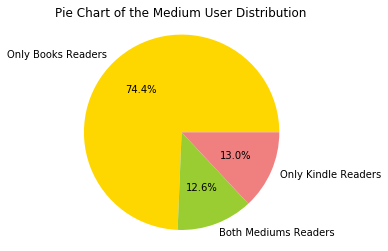

In [52]:
#Pie chart generation
labels = 'Only Books Readers', 'Both Mediums Readers', 'Only Kindle Readers'
sizes = [num_books_users, num_common_users, num_kindle_users]
colors = ['gold', 'yellowgreen', 'lightcoral']
plt.title("Pie Chart of the Medium User Distribution") 
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%')
 
plt.axis('equal')
plt.show()

We also desire to see how many reviews per each user there is. Indeed, we want to see if we have enough users who rated enough products both kinds in order to formulate later proper statistics regarding the tenedecies observed in the consumer's behaviour.

In [10]:
#Number of books ratings per user
books_ratings_user = spark.sql("""SELECT DISTINCT ratings_books.User, COUNT(*) AS num_ratings
             FROM ratings_books 
             WHERE ratings_books.User IN
             (SELECT * FROM common_users)
             GROUP BY ratings_books.User
             SORT BY num_ratings DESC""")

In [94]:
#Registration of the data as a table for further SQL queries
books_ratings_user.registerTempTable("books_ratings_user")

In [31]:
#Number of kindle ratings per user
kindle_ratings_user = spark.sql("""SELECT DISTINCT ratings_kindle.User, COUNT(*) AS num_ratings
             FROM ratings_kindle 
             WHERE ratings_kindle.User IN
             (SELECT * FROM common_users)
             GROUP BY ratings_kindle.User
             SORT BY num_ratings DESC""")

In [96]:
#Registration of the data as a table for further SQL queries
kindle_ratings_user.registerTempTable("kindle_ratings_user")

In [11]:
#Conversion to Pandas Dataframe to handle the data better
df_books_ratings_user = books_ratings_user.toPandas()

In [33]:
#Conversion to Pandas Dataframe to handle the data better
df_kindle_ratings_user = kindle_ratings_user.toPandas()

First we will plot for each of the medium, the distribution of the number of reviews per users as a histogram to grasp a general tendency in the ratings behaviours of the customers.

In [12]:
df_books_ratings_user.index = df_books_ratings_user['User']

In [34]:
df_kindle_ratings_user.index = df_kindle_ratings_user['User']

In [13]:
df_books_ratings_user = df_books_ratings_user.drop(['User'], axis = 1)

In [35]:
df_kindle_ratings_user = df_kindle_ratings_user.drop(['User'], axis = 1)

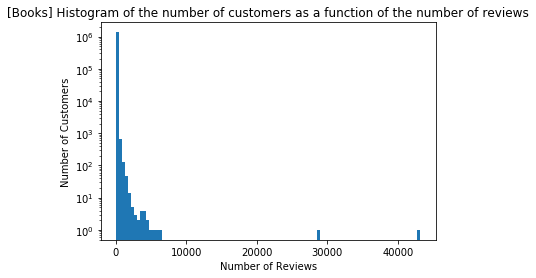

In [180]:
fig, ax = plt.subplots()
plt.title("[Books] Histogram of the number of customers as a function of the number of reviews")
plt.hist(df_books_ratings_user['num_ratings'], bins = 100)
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Customers")
ax.set_yscale('log')

If we remove the outliers.

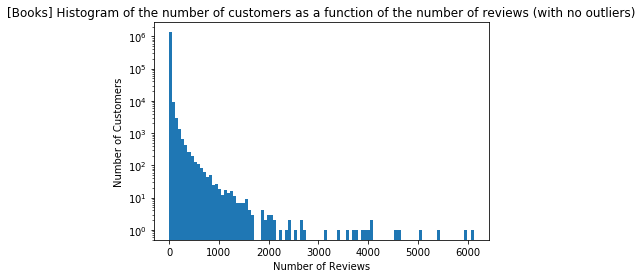

In [181]:
non_outliers_books = df_books_ratings_user[df_books_ratings_user['num_ratings']<10000]['num_ratings']
fig, ax = plt.subplots()
plt.hist(non_outliers_books, bins = 100)
plt.title("[Books] Histogram of the number of customers as a function of the number of reviews (with no outliers)")
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Customers")
ax.set_yscale('log')

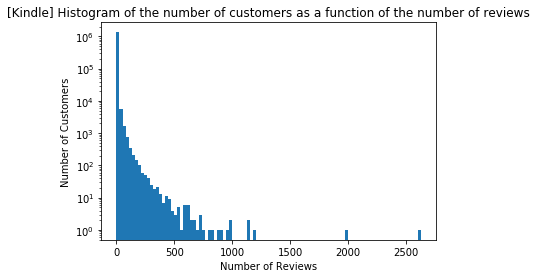

In [182]:
fig, ax = plt.subplots()
plt.hist(df_kindle_ratings_user['num_ratings'], bins = 100)
plt.title("[Kindle] Histogram of the number of customers as a function of the number of reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Customers")
ax.set_yscale('log')

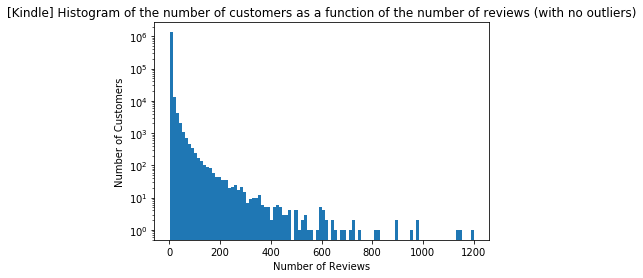

In [183]:
non_outliers_kindle = df_kindle_ratings_user[df_kindle_ratings_user['num_ratings']<1500]['num_ratings']
fig, ax = plt.subplots()
plt.hist(non_outliers_kindle, bins = 100)
plt.title("[Kindle] Histogram of the number of customers as a function of the number of reviews (with no outliers)")
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Customers")
ax.set_yscale('log')

When the outliers are removed, we can see that the distribution is very similar in both cases of the books and the kindle ebooks which leads to the first interpration that the reviewing behaviour are pretty similar.

Let us boxplot the two number of ratings depending on the medium.

In [77]:
df_boxplot_books = df_books_ratings_user.copy()
df_boxplot_books['Type'] = "Book"
df_boxplot_books = df_boxplot_books.reset_index()

df_boxplot_kindle = df_kindle_ratings_user.copy()
df_boxplot_kindle['Type'] = "Kindle"
df_boxplot_kindle = df_boxplot_kindle.reset_index()

df_boxplot = df_boxplot_books.append(df_boxplot_kindle)

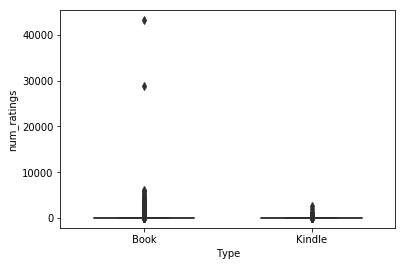

In [78]:
bplot = snb.boxplot(y="num_ratings", x='Type', 
                 data=df_boxplot, 
                 width=0.6,
                 palette="colorblind")

The boxplot are not very concluent, we decide then to compute the main statistical indicator for each of the dataset kindle and books.

In [82]:
num_books_review_user = df_books_ratings_user['num_ratings']
num_kindle_review_user = df_kindle_ratings_user['num_ratings']

In [186]:
books_average = num_books_review_user.mean()
books_variance = statistics.variance(num_books_review_user)
books_median = statistics.median(num_books_review_user)
print("-- Books -- Mean : {}, Median : {}, Variance : {}".format(books_average, books_median, books_variance))

-- Books -- Mean : 6.679168780742828, Median : 2, Variance : 2917.786838323335


In [185]:
kindle_average = num_kindle_review_user.mean()
kindle_variance = statistics.variance(num_kindle_review_user)
kindle_median = statistics.median(num_kindle_review_user)
print("-- Kindle -- Mean : {}, Median : {}, Variance : {}".format(kindle_average, kindle_median, kindle_variance))

-- Kindle -- Mean : 2.318274502662818, Median : 1, Variance : 74.11748866831114


We could conclude that books are overall more popular than kindle but is strongly biased given that we have (not yet at this point) consider the time as a variable factor. Indeed, the kindle only started in Nov 2007 and books are on amazon.com since the very beginning of the website.

We decide to compute also the percentage of kindle ebooks reviewed with respect to all the books and ebooks reviewed for an user.

In [101]:
df_diff_usage = spark.sql("""SELECT books_ratings_user.User, 
                             kindle_ratings_user.num_ratings /
                             (books_ratings_user.num_ratings + kindle_ratings_user.num_ratings) AS kindle_percentage
                             FROM books_ratings_user
                             JOIN kindle_ratings_user
                             ON books_ratings_user.User = kindle_ratings_user.User """)

In [103]:
df_percentage = df_diff_usage.toPandas()

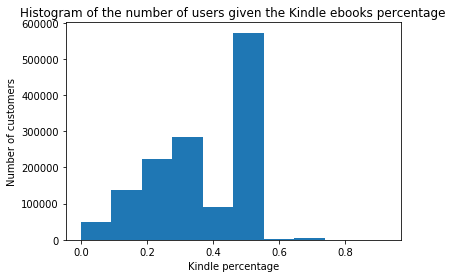

In [189]:
fig, ax = plt.subplots()
plt.title("Histogram of the number of users given the Kindle ebooks percentage")
plt.xlabel("Kindle percentage")
plt.ylabel("Number of customers")
plot = plt.hist(df_percentage["kindle_percentage"], bins = 10)

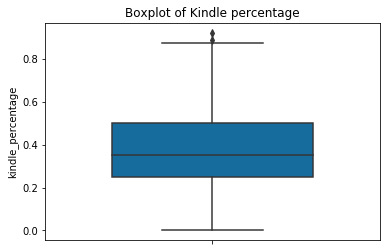

In [190]:
plt.title("Boxplot of Kindle percentage")
plt.ylabel("Percentage")
bplot = snb.boxplot(y="kindle_percentage", 
                 data=df_percentage, 
                 width=0.6,
                 palette="colorblind")

### Grade ratings analysis

Let us also analyze the quality of the reviews i.e. the given rating and not only the number to obtain another point of view on the reviews difference in the two mediums.

In [128]:
#Kindle grades
grade_kindle = spark.sql("""SELECT ratings_kindle.User, AVG(ratings_kindle.Ratings) AS kindle_rating
                           FROM ratings_kindle
                           WHERE ratings_kindle.User IN
                           (SELECT * FROM common_users)
                           GROUP BY ratings_kindle.User""")

In [129]:
#Registration of the data as table for latter SQL queries
grade_kindle.registerTempTable("grade_kindle")

In [130]:
#Books grades
grade_books = spark.sql("""SELECT ratings_books.User, AVG(ratings_books.Ratings) AS book_rating
                           FROM ratings_books
                           WHERE ratings_books.User IN
                           (SELECT * FROM common_users)
                           GROUP BY ratings_books.User""")

In [131]:
#Registration of the data as table for latter SQL queries
grade_books.registerTempTable("grade_books")

In [132]:
#Conversion to pandas dataframes
df_grade_kindle = grade_kindle.toPandas()

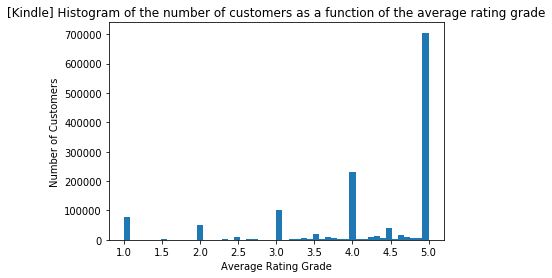

In [192]:
fig, ax = plt.subplots()
plt.title("[Kindle] Histogram of the number of customers as a function of the average rating grade")
plt.xlabel("Average Rating Grade")
plt.ylabel("Number of Customers")
plot = plt.hist(df_grade_kindle['kindle_rating'], bins = 50)

In [133]:
df_grade_books = grade_books.toPandas()

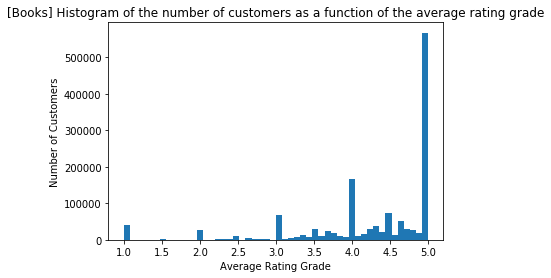

In [194]:
fig, ax = plt.subplots()
plt.title("[Books] Histogram of the number of customers as a function of the average rating grade")
plt.xlabel("Average Rating Grade")
plt.ylabel("Number of Customers")
plot = plt.hist(df_grade_books['book_rating'], bins = 50)

Let us also boxplot the average grade of the rating for the kindle reviews and the books reviews.

In [159]:
df_boxplot_books = df_grade_books.copy()
df_boxplot_books = df_boxplot_books.drop(['User'],axis=1)
df_boxplot_books['Type'] = "Book"
df_boxplot_books=df_boxplot_books.rename(columns={"book_rating": "rating"})
df_boxplot_books = df_boxplot_books.reset_index()

df_boxplot_kindle = df_grade_kindle.copy()
df_boxplot_kindle = df_boxplot_kindle.drop(['User'],axis=1)
df_boxplot_kindle['Type'] = "Kindle"
df_boxplot_kindle=df_boxplot_kindle.rename(columns={"kindle_rating": "rating"})
df_boxplot_kindle = df_boxplot_kindle.reset_index()

df_boxplot = df_boxplot_books.append(df_boxplot_kindle)

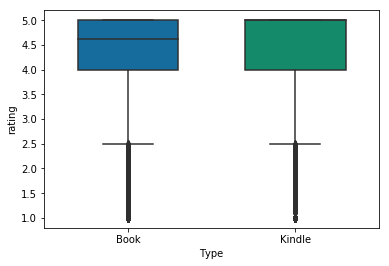

In [161]:
bplot = snb.boxplot(y="rating", x='Type', 
                 data=df_boxplot, 
                 width=0.6,
                 palette="colorblind")

From the previous analysis, as in the previous case of the number of reviews given the medium, we don't see a very important difference in the quality of the grade given for each platform. Both score very well on average with very similar distribution of grades and similar mean.

Eventually, we also compute the difference in the average grade given the medium i.e. `kindle_average_grade - book average_grade` for each customer and get the mean and variance of it in order to obtain a high level interpretation of a tendency.

In [167]:
df_grade_diff = spark.sql("""SELECT DISTINCT grade_books.User, kindle_rating - book_rating AS grade_diff
                             FROM grade_books
                             JOIN grade_kindle 
                             ON grade_books.User = grade_kindle.User""")

In [168]:
pd_df_grade = df_grade_diff.toPandas()

In [171]:
mean_diff = statistics.mean(pd_df_grade["grade_diff"])
mean_diff

-0.09298465338846347

In [173]:
var_diff = statistics.variance(pd_df_grade["grade_diff"])
var_diff

0.3735597544187338

Again, the difference in the grade given the customer is very small and indicates no important variation depending on the medium.

# Conclusion

As we expected, given a first general analysis it is impossible to determine a difference in the customer opinion regarding the reading platform. The results are very similar with very small deviation one from another. It is understandable given that customer usually review the product itself i.e. the content of the book more in depth than the way it was delivered and its cover for a book or the layout of the kindle ebook. Nonetheless, these secondary factors can also play a role in the overall appreciation but at given the first tools we used it is not possible to infer much of it.

# What remains to be done, next steps

As mentionned during our analysis, we can get more insight on the appreciation of a format if we take into account the time as a factor. Indeed, if we observe switch in platforms for a user (going from books to kindle totally), we could interpret this a preference for the later over a period of evaluation of the two mediums. The next step in our analysis will consist on including the time parameter in the equation and observe patterns among customers reading behaviour that changed over time:
- number of books, kindle read in a given period
- change of reading pace
- total switch of platforms
- comeback from a platform to another
- increase or decrease of kindle percentage ebooks over time

In addition to this, we also consider the usage of terms analysis specific to the kindle format as "layout","interactivity", etc. to make the understanding of the kindle ebooks format more precise.